# Segment 3 Lab

## Let's apply a Neural Network to the product price example from Segment 2

In [17]:
# imports - now including pytorch

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import json
import csv
from sklearn.feature_extraction.text import CountVectorizer
from testing import Tester
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.display import display, SVG
from sklearn.model_selection import train_test_split

In [18]:
# Load in dataset
# Sidenote: this is actually a larger dataset than before (about twice as large)

with open('../train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../test.pkl', 'rb') as file:
    test = pickle.load(file)

In [19]:
len(train)

400000

# Wait - just before we make our Neural Network

There is a different kind of Neural Network that I'd like to put to the test.

In [20]:
# Read in results from a Neural Network of the non-artificial kind!!

human_predictions = []
with open('human_output.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [21]:
def human(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 Item: HOLDWILL 6 Pack LED Shop Light, 4FT 24W ...
11: Guess: $90.00 Truth: $254.21 Error: $164.21 

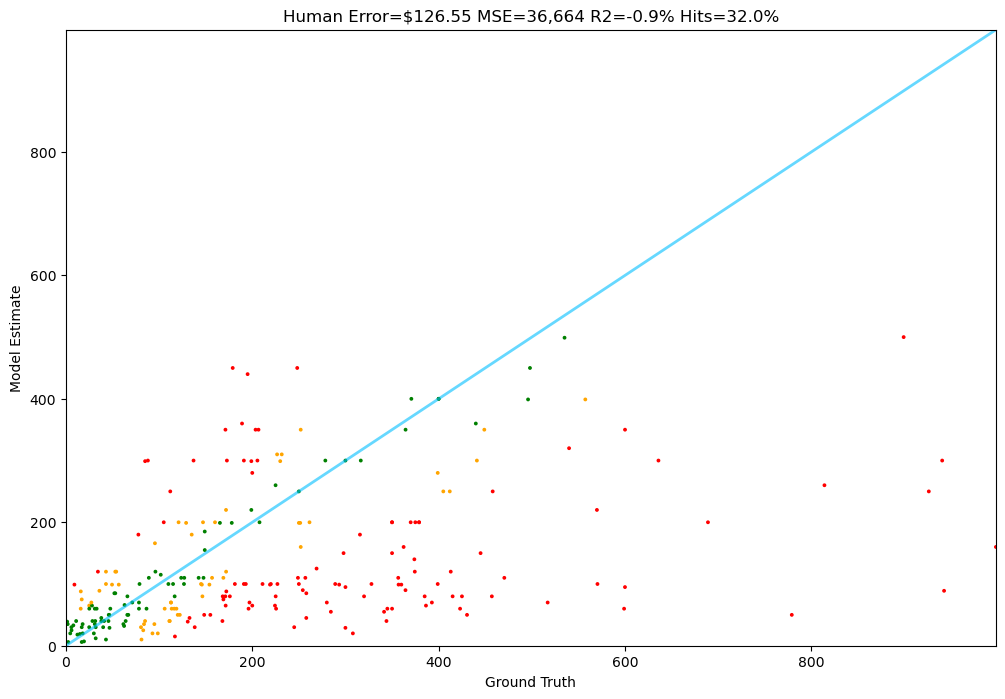

In [22]:
Tester.test(human, test)

# OK now let's go Artificial!

In [23]:
# Prepare our documents and prices

y = np.array([float(item.price) for item in train])
documents = [item.text for item in train]

In [24]:
# Use the CountVectorizer for a Bag of Words model
# Using binary=True with the CountVectorizer makes "one-hot vectors"

np.random.seed(42)
vectorizer = CountVectorizer(max_features=2000, stop_words='english', binary=True)
X = vectorizer.fit_transform(documents)

In [25]:
# Define the neural network - here is Pytorch code to create a 6 layer neural network


class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 64)
        self.layer6 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output1 = self.relu(self.layer1(x))
        output2 = self.relu(self.layer2(output1))
        output3 = self.relu(self.layer3(output2))
        output4 = self.relu(self.layer4(output3))
        output5 = self.relu(self.layer5(output4))
        output6 = self.layer6(output5)
        return output6

params = 2000 * 128 + 128 * 64 + 64 * 64 * 3 + 64
print(f"There are {params:,} parameters in our neural network")

There are 276,544 parameters in our neural network


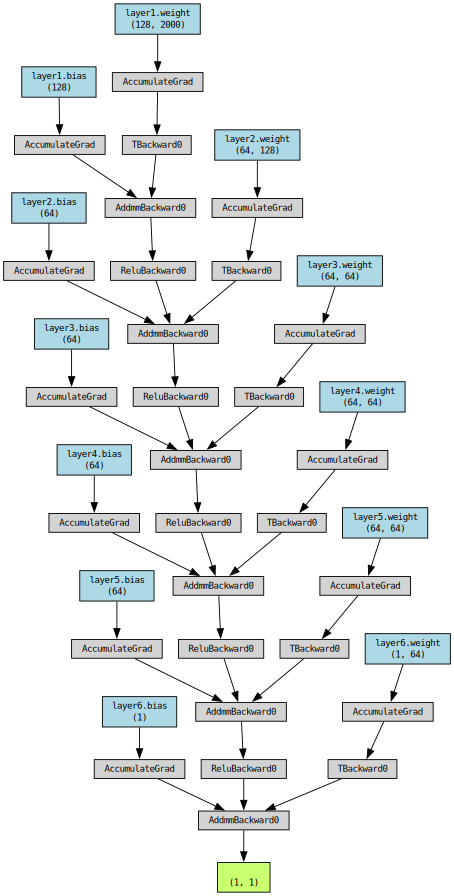

In [26]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X.toarray())
y_train_tensor = torch.FloatTensor(y).unsqueeze(1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.05, random_state=42)

# Create the loader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)

# Create a dummy input and visualize the network
x = torch.randn(1, input_size)
dot = make_dot(model(x), params=dict(model.named_parameters()))
display(SVG(dot.pipe(format='svg')))

# Time for the 4 steps of training

We now carry out the 4 steps of training, for chunks of our data at a time (called 'batches')
1. Forward pass
2. Loss calculation
3. Backward pass (calculate gradients)
4. Optimization (shift the weights a step in the right direction to do better next time)

### The Learning Rate

When Optimizing, we need to decide how big a step to take each time. This is called the "Learning Rate" and it's an important hyperparameter. We will try 0.001.

### Epochs

We will run through the entire dataset several times; each complete run is called an "Epoch"

In [27]:
# Define loss function and optimizer

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# We will do 2 complete runs through the data

EPOCHS = 2

for epoch in range(EPOCHS):
    model.train()
    for batch_X, batch_y in tqdm(train_loader):
        optimizer.zero_grad()

        # The next 4 lines are the 4 stages of training: forward pass, loss calculation, backward pass, optimize
        
        outputs = model(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = loss_function(val_outputs, y_val)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.3f}, Val Loss: {val_loss.item():.3f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11875/11875 [00:42<00:00, 282.04it/s]


Epoch [1/2], Train Loss: 18486.199, Val Loss: 19878.953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11875/11875 [00:37<00:00, 313.73it/s]

Epoch [2/2], Train Loss: 8491.029, Val Loss: 18751.129


In [28]:
def neural_network(item):
    model.eval()
    with torch.no_grad():
        vector = vectorizer.transform([item.text])
        vector = torch.FloatTensor(vector.toarray())
        result = model(vector)[0].item()
    return max(0, result)

In [29]:
test[0].text

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [30]:
test[0].price

374.41

In [31]:
neural_network(test[0])

251.70521545410156

1: Guess: $251.71 Truth: $374.41 Error: $122.70 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $143.07 Truth: $225.11 Error: $82.04 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $138.52 Truth: $61.68 Error: $76.84 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $418.32 Truth: $599.99 Error: $181.67 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $87.49 Truth: $16.99 Error: $70.50 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $40.59 Truth: $31.99 Error: $8.60 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $155.74 Truth: $101.79 Error: $53.95 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $340.82 Truth: $289.00 Error: $51.82 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $451.05 Truth: $635.86 Error: $184.81 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $132.84 Truth: $65.99 Error: $66.85 Item: HOLDWILL 6 Pack LED Shop Light, 4FT 24W ...
11: Guess: $285.89 Truth: $254.21 Error: $31.68 

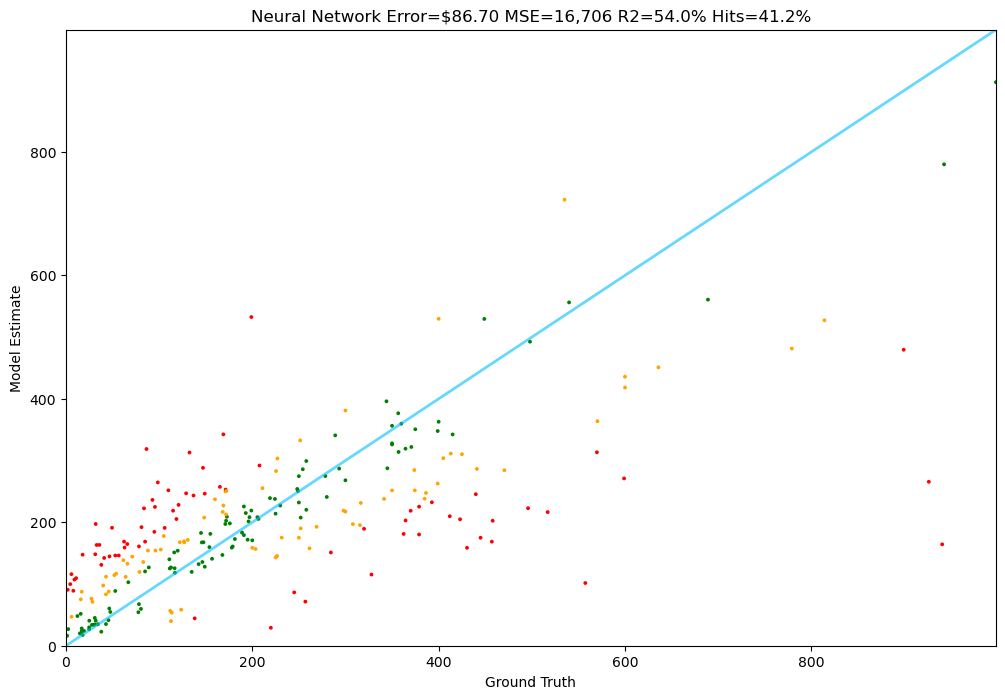

In [32]:
Tester.test(neural_network, test)

# Exercise: Make a Deeper Neural Network!

See how many layers you can add - you may need to look up some tricks to avoid over-fitting - also increase the vocab size